## FPFH + USIP evaluation

### [Table with results](https://docs.google.com/spreadsheets/d/1RFsCrZankJD1TLfr71G5_HNj5l7dGmsuB2aG1zxWT6c/edit?usp=sharing)

### Evaluation process

1. Consider two point clouds that have intersections
2. Calculate USIP keypoints and FPFH keypoint descriptors for both point clouds
3. Apply RANSAC based on FPFH features
4. Compare calculated transformation with GT. If estimated transformation lies in vicinity of GT transformation -- assume as successful match
5. Calculate total matches for all pairs

### Additional experiments:
* Provide RANSAC with initial guess from odometry algorithm (LOAM in our case)
* Divide pairs of point clouds in two groups: consequitive / not consequitive

### Hyperparameters
* FEATURE_RADIUS -- radius for FPFH descriptor estimation
* FEATURE_NN -- count of nearest neighbors for FPFH descriptor estimation
* DISTANCE_THRESHOLD -- max distance between keypoints in RANSAC to consider pair of keypoints as inlier


In [12]:
import open3d as o3d
import numpy as np
import os
import mrob
from scipy import spatial
import pandas as pd

In [13]:
# Number of map in KITTI dataset
MAP = '00'

# Specify here path to downloaded keypoints
KEYPOINTS_PATH = '../keypoints_kitti_64_2/' + MAP + '/'

# Specify here path to odometry GT for KITTI dataset
KITTI_GT_PATH = '../../data_odometry_poses_USIP/dataset/poses/' + MAP + '.txt'

# Path to original point clouds from KITTI dataset
KITTI_PCDS_PATH = '/home/anastasiya/data/data_odometry_velodyne/dataset/sequences/00/velodyne/'

## Utils

In [3]:
# Returns numpy presentation of point cloud
def get_point_cloud(path, is_keypoint=False):
    pcd_np = None
    if path.endswith('npy'):
        pcd_np = np.load(path)
    elif path.endswith('bin'):
        if is_keypoint:
            pcd_np = np.fromfile(path, dtype=np.float32).reshape(-1, 3)
        else:
            pcd_np = np.fromfile(path, dtype=np.float32).reshape(-1, 4)[:, :3]
    else:
        raise Exception('Point cloud format is not supported')
    
    return pcd_np


# Returns open3d point cloud representation
def get_pcd_from_numpy(np_pcd, color=[0, 0, 1]):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np_pcd[:, :3])
    pcd.paint_uniform_color(color)
    return pcd

# Transform point cloud using transformation
def transform_array(np_array, T):
    return mrob.geometry.SE3(T).transform_array(np_array)

# Convert quaternion to SE(3) matrix representation
def quat_to_transform(q):
    quat = np.array(q[3:7], dtype='float64')
    T = np.eye(4, dtype='float64')
    T[:3, :3] =  mrob.geometry.quat_to_so3(quat)
    T[0, 3] = q[0]
    T[1, 3] = q[1]
    T[2, 3] = q[2]
    return T

# set1 -- set of keypoints from pcd1
# set2 -- set of keypoints from pcd2
# T - transformation between pcd1 and pcd2
# return -- correspondes between points based on the distance thresholding
def find_correspondences(set1, set2, T):
    corresp = []
    set2_aligned = transform_array(set2, T)
    set2_aligned_tree = spatial.KDTree(set2_aligned)
    picked_flag = np.zeros(set2.shape[0])
    for i in range(set1.shape[0]):
        dist, ind = set2_aligned_tree.query(set1[i], 1)
        if picked_flag[ind] == 0 and dist / np.linalg.norm(set2[ind]) < DIST_THRESHOLD:
            corresp.append((i, ind))
            picked_flag[ind] = 1
    return corresp

# Since keypoints is not always the same points as in point cloud, they are added
# to the whole point cloud to calculate features
def get_keypoints_features(np_pcd, np_keypoints):
    np_combined = np.concatenate((np_pcd, np_keypoints))

    pcd_combined = get_pcd_from_numpy(np_combined)
    pcd_combined.estimate_normals(
            o3d.geometry.KDTreeSearchParamHybrid(radius=NORMAL_RADIUS, max_nn=NORMAL_NN))

    pcd_fpfh = o3d.registration.compute_fpfh_feature(pcd_combined
                    , o3d.geometry.KDTreeSearchParamHybrid(radius=FEATURE_RADIUS, max_nn=FEATURE_NN))
    
    pcd_fpfh.data = pcd_fpfh.data[:, -np_keypoints.shape[0]:]
    return pcd_fpfh

## Load GT

In [14]:
import csv

kitti_odometry_path = '../data_odometry_poses_USIP/dataset/poses/' + MAP + '.txt'
odometry = []
with open(kitti_odometry_path, newline='') as csvfile:
    odometry_reader = csv.reader(csvfile, delimiter=' ')
    for row in odometry_reader:
        row = [float(i) for i in row]
        odometry.append(np.array(row).reshape(3, 4))

In [15]:
path_x = []
path_y = []
for matrix in odometry:
    path_x.append(float(matrix[0, 3]))
    path_y.append(float(matrix[2, 3]))

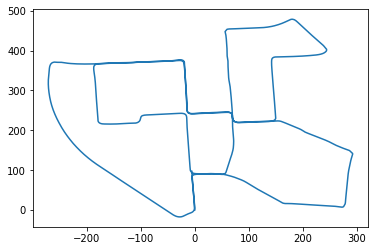

In [16]:
import matplotlib.pyplot as plt

plt.plot(path_x, path_y)
plt.show()

## Load odometry (LOAM)

In [17]:
loam_eval_path = 'LOAM_KITTI_eval/' + MAP + '.txt' 
loam_odom_x = []
loam_odom_y = []
loam_odom = []
with open(loam_eval_path, newline='') as csvfile:
    odometry_reader = csv.reader(csvfile, delimiter=',')
    for row in odometry_reader:
        row = [float(i) for i in row]
        loam_odom.append(row)
        loam_odom_x.append(-row[1])
        loam_odom_y.append(row[0])

## Estimation

### Utils for estimation

In [18]:
def get_transformation(np_pcd, np_keypoints, np_pcd_2, np_keypoints_2):
    keypoints_features = get_keypoints_features(np_pcd, np_keypoints)
    keypoints_features_2 = get_keypoints_features(np_pcd_2, np_keypoints_2)

    distance_threshold = DISTANCE_THRESHOLD

    result = o3d.registration.registration_ransac_based_on_feature_matching(
            get_pcd_from_numpy(np_keypoints), get_pcd_from_numpy(np_keypoints_2)
            , keypoints_features, keypoints_features_2, distance_threshold,
            o3d.registration.TransformationEstimationPointToPoint(False), 4, [
                o3d.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
                o3d.registration.CorrespondenceCheckerBasedOnDistance(
                    distance_threshold)
            ], o3d.registration.RANSACConvergenceCriteria(1000000, 100))


    return result.transformation, np.asarray(result.correspondence_set).shape[0]

def validate(keypoints1, pcd1, keypoints2, pcd2, T_gt, initial_guess=np.eye(4)):
    VAL_TRANSL = 1.2
    VAL_ROT = 0.3
    keypoints_2 = transform_array(keypoints2, initial_guess)
    pcd_2 = transform_array(pcd2, initial_guess)
    T_est, corr = get_transformation(pcd_2, keypoints_2, pcd1, keypoints1)
    T_est = T_est @ initial_guess
    rot_dist = mrob.geometry.SO3(T_est[:3, :3]).distance(mrob.geometry.SO3(T_gt[:3, :3]))
    transl_dist = np.linalg.norm(T_est[:3, 3] - T_gt[:3, 3])
    return transl_dist < VAL_TRANSL and rot_dist < VAL_ROT

In [19]:
def calculate_ransac_measure(guess=False):
    calib_T = np.linalg.inv(np.array([4.276802385584e-04, -9.999672484946e-01, -8.084491683471e-03, -1.198459927713e-02, 
                        -7.210626507497e-03, 8.081198471645e-03, -9.999413164504e-01, -5.403984729748e-02, 
                        9.999738645903e-01, 4.859485810390e-04, -7.206933692422e-03, -2.921968648686e-01,
                       0, 0, 0, 1]).reshape(4, 4))

    keypoint_files = os.listdir(KEYPOINTS_PATH)
    keypoint_files.sort()

    keypoints_prev = None
    pcd_prev = None
    validated_cnt = 0
    T_prev = np.eye(4)
    T_guess_prev = np.eye(4)
    list_of_strangers = []

    for i, filename in enumerate(keypoint_files[:-1]):
        idx = filename.split('.')[0]
        keypoints = transform_array(get_point_cloud(KEYPOINTS_PATH + idx + '.bin', is_keypoint=True), calib_T)
        pcd = get_pcd_from_numpy(get_point_cloud(KITTI_PCDS_PATH + idx + '.bin', is_keypoint=False))
        pcd = pcd.voxel_down_sample(voxel_size=VOXEL_SIZE).points

        T = np.vstack((odometry[int(idx)], np.array([0, 0, 0, 1]))) @ np.linalg.inv(calib_T)
        T_guess = quat_to_transform(loam_odom[int(idx)])

        if not keypoints_prev is None:
            if guess:
                valid_result = validate(keypoints_prev, pcd_prev, keypoints, pcd, np.linalg.inv(T_prev) @ T, 
                                        initial_guess=np.linalg.inv(T_guess_prev) @ T_guess)
            else:
                valid_result = validate(keypoints_prev, pcd_prev, keypoints, pcd, np.linalg.inv(T_prev) @ T)
            if valid_result:
                validated_cnt += 1
            else:
                list_of_strangers.append(i)

        keypoints_prev = keypoints
        pcd_prev = pcd
        T_prev = T
        T_guess_prev = T_guess
    
    return list_of_strangers

### Estimation with initial guess from odometry (LOAM)

In [172]:
table_with_guess = pd.DataFrame()
for FEATURE_RADIUS in [2, 5, 10]:
    for FEATURE_NN in [100, 200, 500, 1000]:
        for DISTANCE_THRESHOLD in [0.2, 0.5, 1]:
            strangers = calculate_ransac_measure(guess=True)
            new_data = pd.DataFrame({'FEATURE_RADIUS': FEATURE_RADIUS,
                                     'FEATURE_NN': FEATURE_NN,
                                     'RANSAC_DIST_THRESHOLD': DISTANCE_THRESHOLD,
                                     'STRANGERS_CNT': len(strangers),
                                     'STRANGERS': strangers})
            table_with_guess.append(new_data)
            print('FEATURE_RADIUS: {0}\nFEATURE_NN: {1}\nDIST_THRESH: {2}\n'.format(FEATURE_RADIUS, FEATURE_NN, DISTANCE_THRESHOLD))
            print('Cnt: {0}'.format(len(strangers)))
            print(strangers)

FEATURE_RADIUS: 1
FEATURE_NN: 100
DIST_THRESH: 0.05

Cnt: 72
[14, 20, 28, 31, 32, 33, 36, 38, 40, 52, 55, 68, 81, 82, 95, 96, 97, 98, 100, 101, 102, 103, 116, 124, 129, 130, 137, 139, 142, 149, 154, 157, 159, 181, 200, 202, 204, 211, 214, 215, 226, 227, 233, 236, 237, 239, 240, 253, 254, 255, 261, 269, 274, 281, 284, 289, 302, 303, 306, 312, 319, 326, 339, 341, 344, 345, 346, 347, 365, 368, 369, 370]
FEATURE_RADIUS: 1
FEATURE_NN: 100
DIST_THRESH: 0.05

Cnt: 40
[36, 68, 81, 87, 96, 100, 101, 130, 139, 143, 149, 154, 157, 159, 181, 199, 204, 211, 214, 222, 226, 227, 233, 236, 237, 240, 253, 254, 255, 261, 274, 284, 289, 303, 312, 319, 326, 334, 344, 345]
FEATURE_RADIUS: 1
FEATURE_NN: 100
DIST_THRESH: 0.05

Cnt: 35
[36, 40, 68, 81, 87, 96, 98, 102, 103, 130, 137, 157, 159, 181, 200, 211, 214, 222, 226, 227, 233, 236, 237, 239, 253, 255, 261, 274, 284, 303, 312, 319, 326, 344, 345]
FEATURE_RADIUS: 1
FEATURE_NN: 200
DIST_THRESH: 0.05

Cnt: 77
[6, 14, 18, 20, 26, 28, 31, 32, 33, 36, 38, 40, 

FEATURE_RADIUS: 10
FEATURE_NN: 1000
DIST_THRESH: 0.05

Cnt: 8
[84, 97, 208, 214, 236, 237, 288, 341]
FEATURE_RADIUS: 10
FEATURE_NN: 1000
DIST_THRESH: 0.05

Cnt: 7
[84, 97, 200, 214, 236, 237, 288]


### Estimation without initial guess

In [176]:
for FEATURE_RADIUS in [2, 5, 10]:
    for FEATURE_NN in [100, 200, 500, 1000]:
        for DISTANCE_THRESHOLD in [0.2, 0.5, 1]:
            strangers = calculate_ransac_measure(guess=False)
            print('FEATURE_RADIUS: {0}\nFEATURE_NN: {1}\nDIST_THRESH: {2}\n'.format(FEATURE_RADIUS, FEATURE_NN, DISTANCE_THRESHOLD))
            print('Cnt: {0}'.format(len(strangers)))
            print(strangers)

FEATURE_RADIUS: 2
FEATURE_NN: 100
DIST_THRESH: 0.2

Cnt: 48
[10, 16, 23, 32, 33, 43, 54, 68, 69, 95, 96, 97, 99, 101, 102, 103, 119, 127, 142, 149, 150, 154, 166, 190, 200, 211, 214, 220, 226, 227, 237, 239, 254, 255, 265, 275, 283, 284, 297, 312, 319, 320, 325, 337, 341, 345, 381, 385]
FEATURE_RADIUS: 2
FEATURE_NN: 100
DIST_THRESH: 0.5

Cnt: 20
[16, 23, 32, 43, 54, 68, 95, 96, 103, 119, 127, 140, 150, 200, 237, 283, 312, 325, 381, 385]
FEATURE_RADIUS: 2
FEATURE_NN: 100
DIST_THRESH: 1

Cnt: 18
[16, 32, 43, 54, 68, 95, 96, 103, 119, 127, 190, 200, 211, 214, 237, 265, 283, 312]
FEATURE_RADIUS: 2
FEATURE_NN: 200
DIST_THRESH: 0.2

Cnt: 44
[10, 15, 16, 31, 32, 33, 54, 68, 97, 98, 100, 102, 103, 127, 149, 150, 152, 200, 211, 212, 214, 218, 236, 237, 240, 265, 273, 274, 275, 276, 283, 284, 288, 292, 297, 312, 316, 319, 322, 328, 341, 344, 345, 385]
FEATURE_RADIUS: 2
FEATURE_NN: 200
DIST_THRESH: 0.5

Cnt: 19
[1, 16, 33, 54, 68, 97, 103, 200, 211, 237, 240, 265, 274, 288, 312, 322, 345, 350, 38